In [1]:
__author__ = "me"
__date__ = "2016_02_01"


import matplotlib
matplotlib.use('Agg')


%pylab inline


import matplotlib.pyplot as plt

import sqlite3
import datetime
import dateutil.parser

import pandas as pd

import geopandas as gp
from shapely.geometry import Point
from geopandas.tools import sjoin
import pysal

from palettable.cubehelix import red_16_r

import os
import ast

Populating the interactive namespace from numpy and matplotlib


In [21]:
def getSQLiteTweets(path):
    '''gets all data as tuple'''
    conn = sqlite3.connect(path)
    data = conn.cursor().execute('SELECT * FROM tweets').fetchall() ## all but raw data
    conn.close()
    return data

def getDF(path):
    data = getSQLiteTweets(path)
    columns = ('id','timestamp','lon', 'lat', 'tweet', 'user_id', 'rtwts', 'fvrts', 'application', 'source')
    
    return pd.DataFrame(data, columns=columns )
    

In [22]:
def toGeoDataFrame(df, lat='Latitude',lon='Longitude'):
    '''dataframe to geodataframe'''
    df['geometry'] = df.apply(lambda z: Point(z[lon], z[lat]), axis=1)
    df = gp.GeoDataFrame(df)
    df.crs = {'init': 'epsg:4326', 'no_defs': True}
    return df 

In [23]:
def averageWeek(df, ax, tcol='ts', ccol='id', label=None, treshold=0, normalize=True, **kwargs):
    '''calculate average week on ts'''
    
    s = df[[tcol, ccol]].rename(columns={tcol:'ts',ccol:'id'}) # rename to convention
    
    s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count').reset_index()
    s['id'] = s['id'].astype(float)


    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg('mean')
    
    
    if s.id.sum() >= treshold:
        if normalize:
            s = 1.0*s/s.sum()
        else:
            pass
        
        if label:
            s.rename(columns={'id':label}, inplace=1)
        
        s.plot(ax=ax, legend=False, **kwargs);

        
        
    else:
        print name, 'didnt pass treshhold:', s[name].sum()
        pass
    
    return g

In [24]:
path = '/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/data/out_DB/2016-02-08 17:49:32_all.db'
df = getDF(path)

In [25]:
df['ts'] = pd.to_datetime(df.timestamp, unit='s')
df['ts'] = df['ts'] - datetime.timedelta(hours=5) ## UTS - 5h NYC

In [26]:
gdf  = toGeoDataFrame(df, lat='lon',lon='lat')  ### mesed with lat_long

In [27]:
gdf.columns

Index([u'id', u'timestamp', u'lon', u'lat', u'tweet', u'user_id', u'rtwts',
       u'fvrts', u'application', u'source', u'ts', u'geometry'],
      dtype='object')

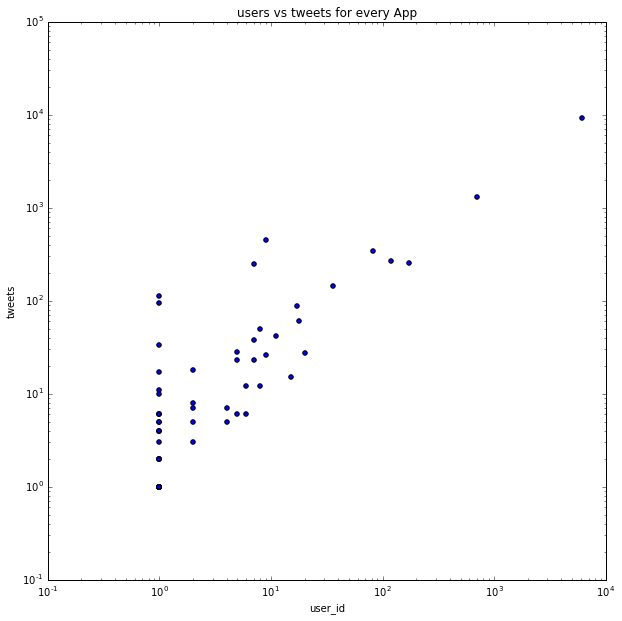

In [28]:
apps = gdf[['application','user_id', 'id']].groupby('application').agg({'user_id':pd.Series.nunique, 'id':'count'}).sort_values(by='user_id', ascending=0)
apps.rename(columns={'id':'tweets'}, inplace=1)
apps.plot(kind='scatter', x='user_id', y='tweets', logy=1, logx=1, figsize=(10,10), title='users vs tweets for every App');


In [29]:
len(gdf)

668586

In [30]:
len(gdf[(gdf.tweet.str.contains("I'm at")) | (gdf.application == 'Foursquare')])

41561

In [31]:
1.0 * len(gdf[(gdf.tweet.str.contains("I'm at")) | (gdf.application == 'Foursquare')])/len(gdf)

0.06216253406442851

In [14]:
apps.head(10)

,user_id,tweets
application,,
Instagram,6120,9164
Foursquare,701,1313
Squarespace,174,252
Twitter for iPhone,119,267
Twitter for Android,82,341
Tweetbot for iΟS,36,145
Untappd,20,27
Twitter for Windows Phone,18,60
Twitter for Android Tablets,17,88


In [15]:
apps[apps.index.str.lower().str.contains('twitter')]
# apps.index

,user_id,tweets
application,,
Twitter for iPhone,119,267
Twitter for Android,82,341
Twitter for Windows Phone,18,60
Twitter for Android Tablets,17,88
twitterfeed,11,42
Twitter for iPad,6,12
Twitter for BlackBerry,4,5
Twitterrific,1,1
Twitter for Android,1,1


Authentic Jobs didnt pass treshhold:

KeyError: u'Authentic Jobs'

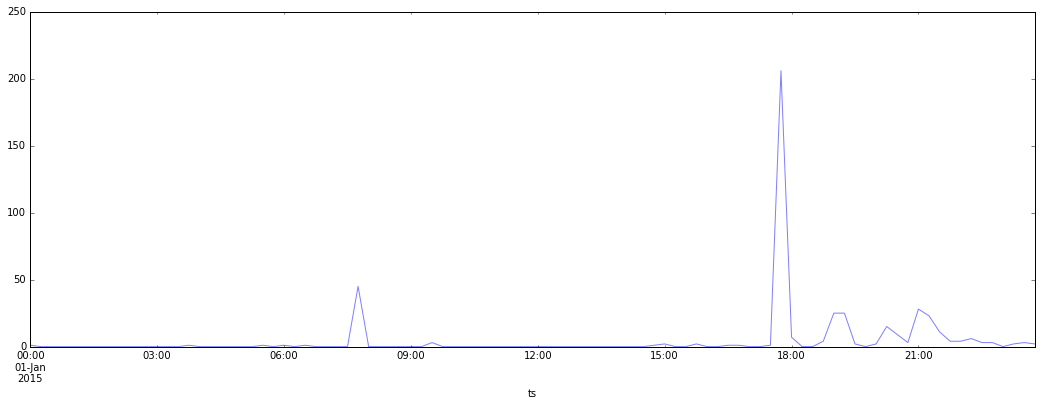

In [20]:
fig, ax = plt.subplots(figsize=(18,6))

weeks = []

treshold = 100

for name, g in gdf.groupby('application'):
    weeks.append(averageWeek(g, ax=ax, label=name, alpha=.5, treshold=treshold, normalize=False ))
    
ax.legend()

## ZIPS

In [87]:
zipPath = '/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]

In [18]:
zips.head(2)

,geometry,postalCode
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004


In [19]:
zips.crs

{'init': u'epsg:4326'}

In [20]:
gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [21]:
gdf2 = sjoin(gdf, zips, how="left")


In [22]:
# gdf2.head(2)

In [23]:
gdf2.postalCode.value_counts().head(5)

10007    73381
10001    28688
10036    27254
10019    23309
10013    23045
Name: postalCode, dtype: int64

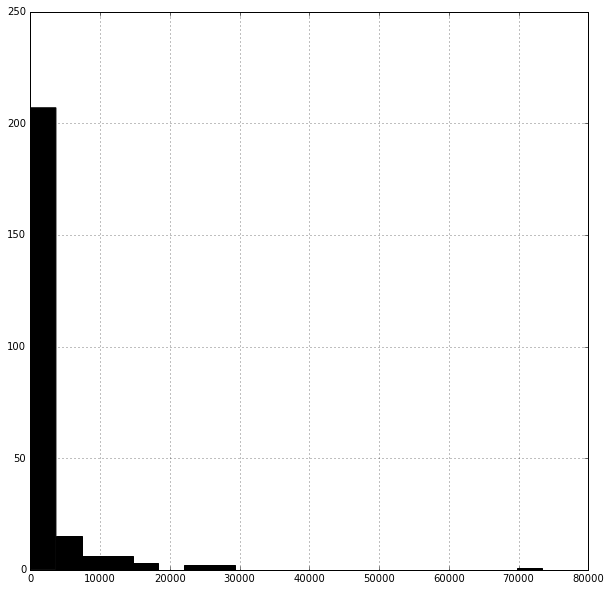

In [153]:
gdf2.postalCode.value_counts().hist(bins=20, figsize=(10,10), color='k');

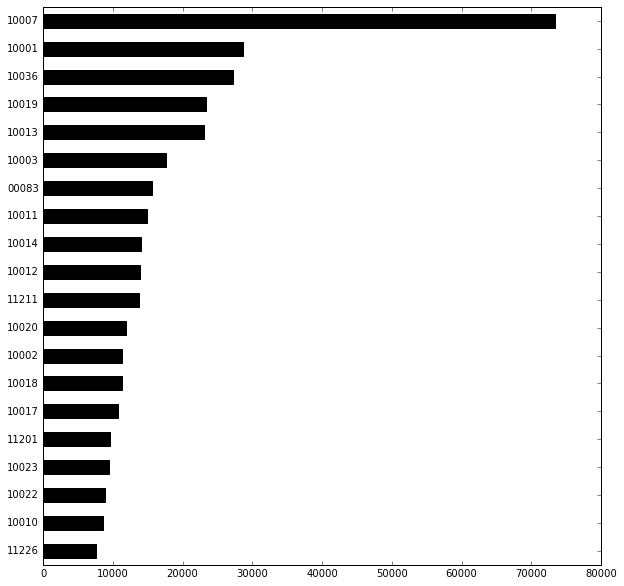

In [152]:
gdf2.postalCode.value_counts().sort_values(axis=0, ascending=False, inplace=0).head(20).iloc[::-1].plot(kind='barh', figsize=(10,10), color='k');
# plt.title('20 ZIPCODES with the most geolocated tweets')

## MAPPING ZIPS

In [156]:
zipheat = gdf2.postalCode.value_counts().reset_index().rename(columns={'index':'postalCode','postalCode':'tweetsTotal'})
zipheat.head(2)

,postalCode,tweetsTotal
0,10007,73381
1,10001,28688


In [157]:
zips2 = zips.merge(zipheat, on='postalCode', how='left')
zips2['normalized'] = zips2['tweetsTotal'] / zips2.geometry.area

In [158]:
zips2.head(2)

,geometry,postalCode,tweetsTotal,normalized
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1106,5530679.241126
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,37,165091.227329


In [281]:
zips2.tweetsTotal.sum()

625986.0

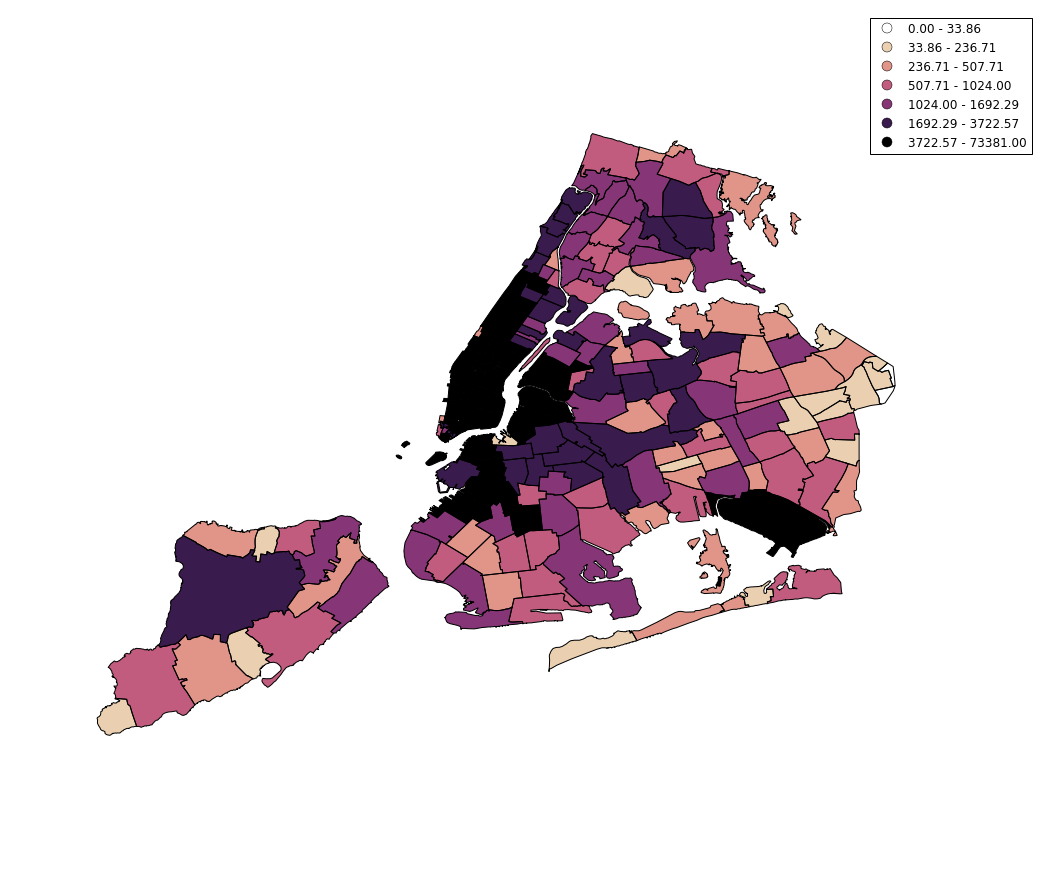

In [216]:
zips2[pd.notnull(zips2.tweetsTotal)].plot(column='tweetsTotal', scheme='QUANTILES', k=7, 
           colormap=red_16_r.mpl_colormap, figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Total Number of tweets per zipcode', fontsize=20)
plt.axis('off');

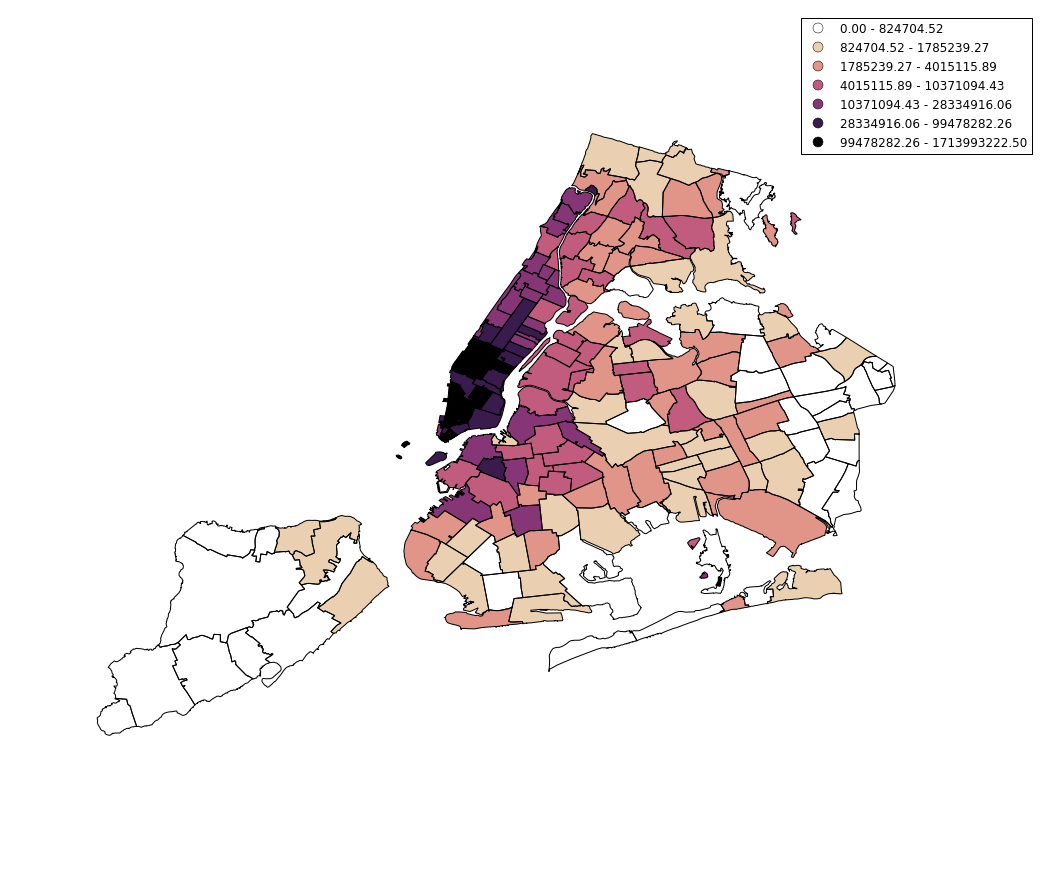

In [217]:
zips2[pd.notnull(zips2.tweetsTotal)].plot(column='normalized', scheme='QUANTILES', k=7, 
           colormap=red_16_r.mpl_colormap, figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Number of tweets per zipcode, normalized by area', fontsize=20)
plt.axis('off');

## AVERAGE WEEK

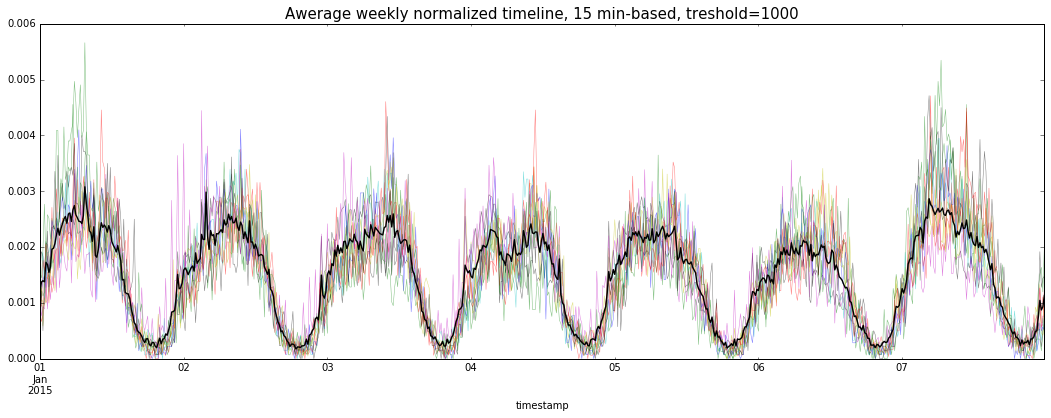

In [201]:

fig, ax = plt.subplots(figsize=(18,6))

weeks = []

treshold = 1000

for name, g in gdf2.groupby('postalCode'):
    zs = averageWeek(g, ax=ax, name=name, alpha=.5, treshold=treshold, lw=.5)
    weeks.append(zs)
    
data = pd.concat(weeks, axis=1)

    
    
    
d = data.mean(axis=1)
(1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k')

    # ax.legend()
ax.set_title('Awerage weekly normalized timeline, 15 min-based, treshold=%d' % treshold, fontsize=15);
    

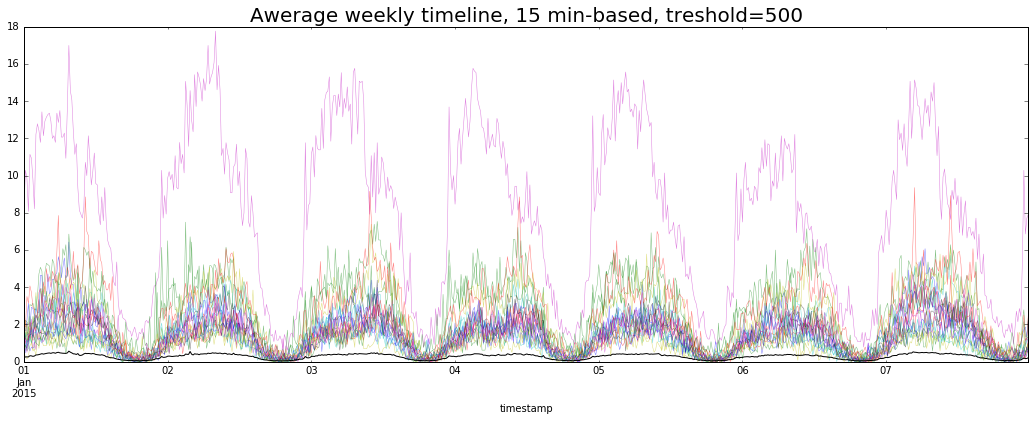

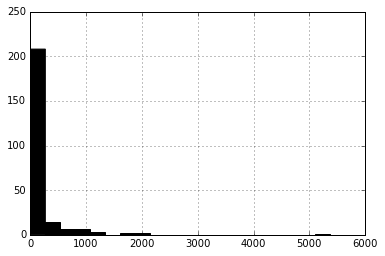

In [149]:
pd.DataFrame(data=zipSum, columns=('postalCode','tweet_sum'))['tweet_sum'].hist(color='k', bins=20);

## ROBOTS

In [219]:
users = gdf2.user_id.value_counts()
top = users.head(30).index.tolist()
singles = users[users==1].index.tolist()

cleanData = gdf2[(~gdf2.user_id.isin(top[:21])) & (~ gdf2.user_id.isin(singles)) ]

In [220]:
len(cleanData)

563100

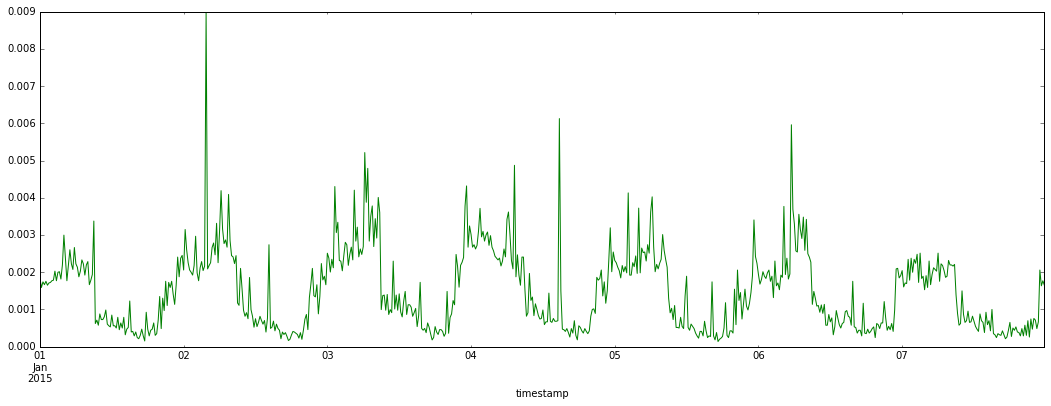

In [221]:
fig, ax = plt.subplots(figsize=(18,6))

x = averageWeek(gdf2[gdf2.user_id.isin(top[:21])], ax=ax, name = 'robots', alpha=1, treshold=0, lw=1)

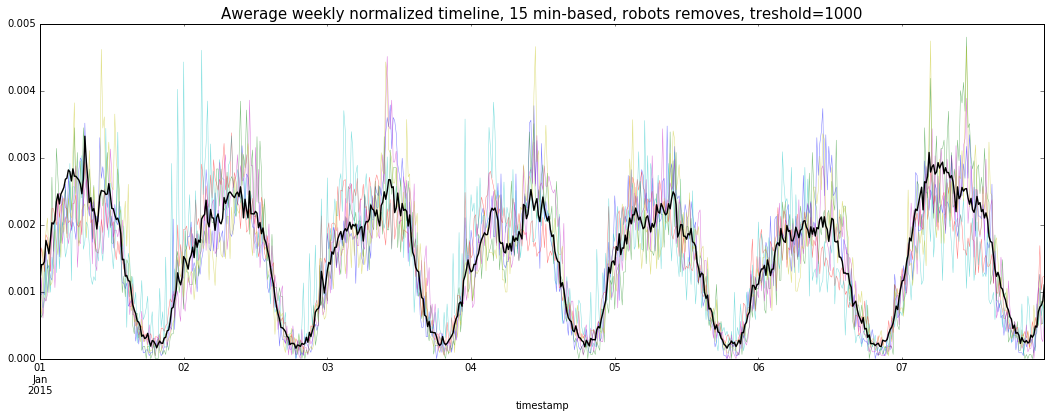

In [246]:
fig, ax = plt.subplots(figsize=(18,6))

weeks = []

treshold = 1000

for name, g in cleanData.groupby('postalCode'):
    zs = averageWeek(g, ax=ax, name=name, alpha=.5, treshold=treshold, lw=.5)
    weeks.append(zs)
    
data = pd.concat(weeks, axis=1)

    

d = data.mean(axis=1)
dn = 1.0*d/d.sum()
dn.plot(ax=ax, lw=1.4, color='k')

    # ax.legend()
ax.set_title('Awerage weekly normalized timeline, 15 min-based, robots removes, treshold=%d' % treshold, fontsize=15);
    

In [241]:
LM = [str(x) for x in [10004, 10005, 10006, 10007, 10038, 10280]]

In [242]:
LM

['10004', '10005', '10006', '10007', '10038', '10280']

In [245]:
LMdata = cleanData[cleanData.postalCode.isin(LM)]

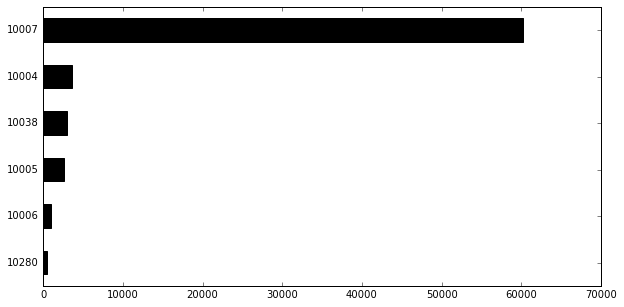

In [262]:
LMdata.postalCode.value_counts().iloc[::-1].plot(kind='barh', color='k', figsize=(10,5))

In [322]:
LMdata.head()

,id,timestamp,lon,lat,tweet,user_id,rtwts,fvrts,application,source,ts,geometry,index_right,postalCode
224,662038522858106881,1446695258,40.714200,-74.006400,🌆 | #nyc #officeview #instagramnyc #vscocam @...,129861900,NaN,NaN,None,twitter1.db,2015-11-05 08:47:38,POINT (-74.0064 40.7142),129,10007
239,662038789066502144,1446695322,40.714200,-74.006400,Halibut Ceviche with Mango. Check it out on pa...,242079218,NaN,NaN,None,twitter1.db,2015-11-05 08:48:42,POINT (-74.0064 40.7142),129,10007
248,662038960177152008,1446695362,40.714353,-74.005973,"If you're a #IT professional in #NewYork, NY, ...",99353722,NaN,NaN,None,twitter1.db,2015-11-05 08:49:22,POINT (-74.00597310000001 40.7143528),129,10007
288,662039430232870912,1446695474,40.706857,-74.011256,"Papa John's shares fall 14% on revenue drop, w...",28918980,NaN,NaN,None,twitter1.db,2015-11-05 08:51:14,POINT (-74.01125589999999 40.70685703),136,10005
293,662039516794986497,1446695495,40.710338,-74.004571,My pumas are so cute but hurt my feet so bad,57055336,NaN,NaN,None,twitter1.db,2015-11-05 08:51:35,POINT (-74.00457065000001 40.71033786),132,10038


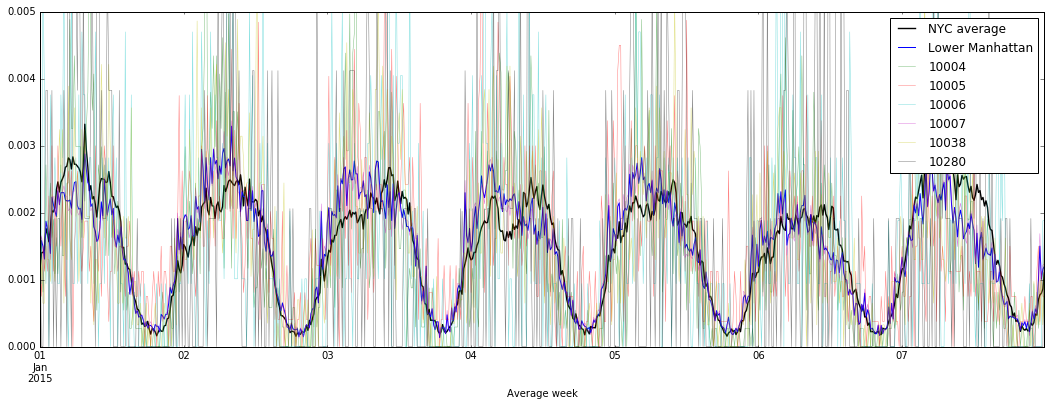

In [468]:
fig, ax = plt.subplots(figsize=(18,6))

dn.plot(ax=ax, lw=1.4, color='k', label='NYC average');
x = averageWeek(LMdata, ax=ax, label='Lower Manhattan', alpha=1, lw=1)

names = ['NYC average', 'Lower Manhattan']

for name, g in LMdata.groupby('postalCode'):
    zs = averageWeek(g, ax=ax, label=name, alpha=.5, lw=.5)
    names.append(name)

# # # plt.title('Lower Manhattan awerage week timeline')
ax.set_ylim([0,0.005]);

x = [datetime.datetime(year=2015, month=1, day=i) for i in range(1,8)]
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


plt.sca(ax)

# ax.set_xticks(x, labels, color='red');
ax.set_xticks(x, labels);
# ax.set_xticklabels(labels);
plt.xlabel('Average week')
plt.legend();

In [280]:
len(gdf)

668586

In [283]:
len(LMdata)

70945

NameError: name 'LMdata' is not defined

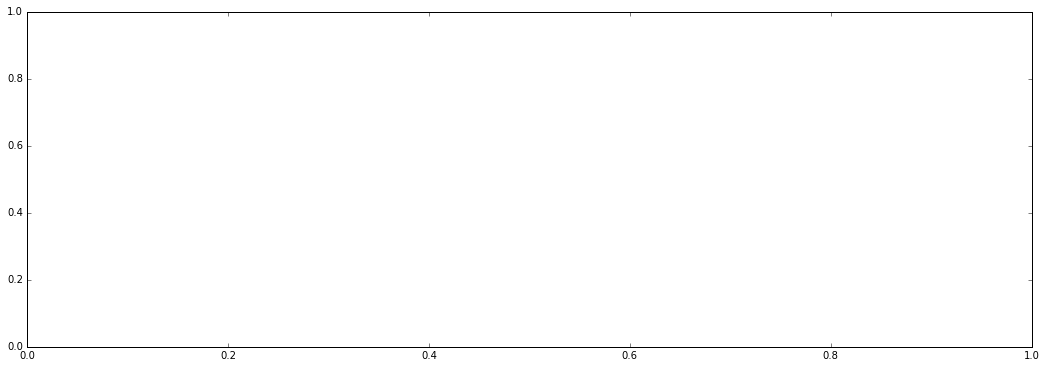

In [9]:
fig, ax = plt.subplots(figsize=(18,6))

x = averageWeek(LMdata, ax=ax, label='Lower Manhattan', alpha=1, lw=1)

x = [datetime.datetime(year=2015, month=1, day=i) for i in range(1,8)]
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


ax.set_xticklabels([],minor=False) # the default
ax.set_xticklabels([],minor=True)

plt.xlabel('Average week')
plt.legend(names);
plt.legend()
plt.xticks(x, labels, color='red');

In [32]:
import os
pids = [pid for pid in os.listdir('/proc') if pid.isdigit()]

OSError: [Errno 2] No such file or directory: '/proc'